### Problem Narrative:
When traveling to Paris and booking Airbnb for a vacation, I try to spend less on lodging to be able to afford good dining and tours.  I find that the options close to the centre, that is close to the top attractions i.e. Eiffel tower, Champs Elysees are pricier, and most of the properties are unavailable as well, so I end up staying further from the centre, and when I do, I am always worried that I might have booked a property that is way too far out from the centre of the city, and or far from a metro station -- since actual location is not provided until after you have made the reservation, or unless you contact host and ask.  Distance to the station is relative depending on how far one is willing to walk, but for me, more than a mile to a station is considered far, since I feel I have to save all my energy for the leisurely walking one does around Paris.

The goals are:

1) to be able to explore and answer the following questions:

* How does location influence property rental price and reviews?  What are the options for being able to stay close to the centre?

* What other features drive the price of an airbnb rental property?

  i.e. price vs location, price vs distance from a top attraction, etc.



2) recommend Airbnb properties given a certain criteria, and enable a more informed decision for the traveler: TBD

* walking distance to one of the top attractions (within 2 miles)
* walking distance to metro station (within 1 mile)
* rating >= 9

* other user defined criteria i.e. 
* number of beds
* number of bedrooms
* price range
* type of property

** Some caveats and assumptions:
Property locations provided by Airbnb in the dataset are a few meters off than the actual property.



In [1]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium

In [3]:
import pandas as pd
import numpy as np
import json
import ijson
from datetime import datetime, timedelta

In [4]:
import os, sys
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pivottablejs
import missingno as msno
import pandas_profiling

import ipywidgets as widgets

import sklearn
import scipy


In [6]:
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':16,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

In [7]:
json_data_path = 'airbnb_paris/airbnb-listings.geojson.json'
with open(json_data_path, 'r') as f:
    objects = ijson.items(f, 'features.item')
    columns = list(objects)

In [8]:
#check that the expected number of rows have been read
len(columns)

54513

In [9]:
selected_row = []
for col in columns:
    temp = col['properties']
    selected_row.append(temp)

In [10]:
len(selected_row)

54513

In [11]:
#load all rows to a dataframe
df = pd.DataFrame(selected_row)
pd.set_option('display.max_columns',500)

In [12]:
len(df.columns)

86

In [13]:
df.columns

Index(['access', 'accommodates', 'amenities', 'availability_30',
       'availability_365', 'availability_60', 'availability_90', 'bathrooms',
       'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count',
       'calendar_last_scraped', 'calendar_updated', 'cancellation_policy',
       'city', 'cleaning_fee', 'country', 'country_code', 'description',
       'experiences_offered', 'extra_people', 'features', 'first_review',
       'geolocation', 'guests_included', 'host_about', 'host_id',
       'host_listings_count', 'host_location', 'host_name',
       'host_neighbourhood', 'host_picture_url', 'host_response_rate',
       'host_response_time', 'host_since', 'host_thumbnail_url',
       'host_total_listings_count', 'host_url', 'host_verifications',
       'house_rules', 'id', 'interaction', 'jurisdiction_names', 'last_review',
       'last_scraped', 'latitude', 'license', 'listing_url', 'longitude',
       'market', 'maximum_nights', 'medium_url', 'minimum_nights',
       'm

1) Delete unnecessary columns which will not be used for analysis, such as:
    calendar_last_scraped, calendar_updated, city, listing_url, host_picture_url, etc.

In [14]:
dfParis = df[['access','accommodates','amenities','availability_30','availability_60','availability_90','bathrooms','bedrooms','beds',
              'cancellation_policy','cleaning_fee','guests_included','host_since','host_total_listings_count',
              'id','last_review','latitude','longitude','minimum_nights','neighborhood_overview','neighbourhood_cleansed',
              'number_of_reviews','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value','reviews_per_month','room_type','summary','transit','zipcode']
            ].copy()

2) Look at individual columns and check for unique values

In [15]:
dfParis['neighbourhood_cleansed'].value_counts()

Buttes-Montmartre      6315
Popincourt             5381
Vaugirard              4000
Entrepôt               3749
Batignolles-Monceau    3547
Ménilmontant           2981
Buttes-Chaumont        2951
Passy                  2895
Opéra                  2391
Temple                 2368
Observatoire           2161
Reuilly                2156
Panthéon               1989
Gobelins               1940
Hôtel-de-Ville         1927
Luxembourg             1846
Palais-Bourbon         1709
Bourse                 1620
Élysée                 1459
Louvre                 1128
Name: neighbourhood_cleansed, dtype: int64

In [16]:
dfParis['property_type'].value_counts()

Apartment             52090
Loft                    602
House                   557
Bed & Breakfast         394
Condominium             253
Other                   159
Boutique hotel          114
Townhouse                73
Guesthouse               71
Dorm                     64
Hostel                   33
Boat                     31
Serviced apartment       27
Villa                    14
Cabin                    14
Timeshare                 4
Camper/RV                 2
Igloo                     2
Cave                      2
Bungalow                  2
Earth House               2
Chalet                    1
Treehouse                 1
Tipi                      1
Name: property_type, dtype: int64

In [17]:
dfParis['room_type'].value_counts()

Entire home/apt    46897
Private room        7073
Shared room          543
Name: room_type, dtype: int64

In [18]:
print(dfParis['review_scores_rating'].isnull().sum())
print(dfParis['review_scores_value'].isnull().sum())
print(dfParis['review_scores_cleanliness'].isnull().sum())
print(dfParis['review_scores_accuracy'].isnull().sum())
print(dfParis['review_scores_checkin'].isnull().sum())
print(dfParis['review_scores_communication'].isnull().sum())
print(dfParis['review_scores_location'].isnull().sum())


14250
14375
14330
14355
14378
14335
14368


In [19]:
dfParis['zipcode'].value_counts()

75018           6260
75011           5312
75015           3951
75010           3782
75017           3520
75020           3040
75019           2843
75009           2375
75003           2198
75012           2134
75014           2134
75005           1998
75004           1922
75013           1915
75006           1833
75007           1614
75002           1582
75016           1446
75116           1392
75008           1378
75001           1102
92130             17
75                 4
75000              3
93300              3
92100              3
Paris              2
92300              2
94160              2
75011\n75011       2
75011 PARIS        1
Paris 75004        1
750109             1
78005              1
75014\n75014       1
075016             1
750016             1
adf                1
75106              1
Montmartre         1
75018e             1
75 018             1
92200              1
750018             1
92240              1
76016              1
94250              1
92170        

Researching Paris zip codes, it appears that zip codes 75001 through 75020 corresponds to 1st Arrondissement through 20th Arrondissemant in the city.

More information on Paris Arrondissements in wikipedia: https://en.wikipedia.org/wiki/Arrondissements_of_Paris


Since we want to focus the analysis for properties within Analysis will be focused in these zip codes, we can delete the rows outside of these zip codes.

In [20]:
zipcodes = [str(x) for x in range(75001, 75021) ]
dfParis = dfParis[dfParis['zipcode'].isin(zipcodes)]
dfParis['zipcode'].value_counts()

75018    6260
75011    5312
75015    3951
75010    3782
75017    3520
75020    3040
75019    2843
75009    2375
75003    2198
75014    2134
75012    2134
75005    1998
75004    1922
75013    1915
75006    1833
75007    1614
75002    1582
75016    1446
75008    1378
75001    1102
Name: zipcode, dtype: int64

In [21]:
#get number of rows after deleting other zipcodes
len(dfParis['zipcode'])

52339

Let us add a column 'arrondissement' so we can refer to the area by arrondissement rather than the zip code:

In [22]:
def get_arrond(row):
    ''' this function returns the arrondissement number based on the zipcode'''
    
    return int(row['zipcode'][-2:])

In [23]:
dfParis['arrondissement'] = dfParis.apply(lambda x: get_arrond(x), 1)
dfParis.head()

,access,accommodates,amenities,availability_30,availability_60,availability_90,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,last_review,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,summary,transit,zipcode,arrondissement
0,NaN,4,"TV,Internet,Wireless Internet,Kitchen,Elevator...",0,0,0,1,1.0,2.0,moderate,30.0,1,2014-12-05,1.0,13080857,2016-09-25,48.85863353454054,2.3012819050784645,1,The Champs de Mars is at the foot of the flat....,Palais-Bourbon,7,210.0,Apartment,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.72,Entire home/apt,The flat is in the heart of Paris at the foot ...,2 metro stations (Alma Marceau line 9 and Ecol...,75007,7
1,NaN,4,"TV,Wireless Internet,Kitchen,Heating,Family/ki...",8,13,32,1,1.0,1.0,strict,NaN,1,2016-12-03,1.0,16227135,2017-01-04,48.85432599122943,2.297999669163623,7,NaN,Palais-Bourbon,1,150.0,Apartment,10.0,8.0,10.0,8.0,10.0,80.0,10.0,0.32,Entire home/apt,Grand appartement confortable et traversant de...,NaN,75015,15
2,NaN,4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",9,21,31,1,1.0,1.0,strict,55.0,2,2015-02-24,35.0,11908897,2017-03-31,48.859675450152054,2.3288315242670463,2,Saint Germain des Pres is the most sought by t...,Palais-Bourbon,34,180.0,Apartment,10.0,9.0,10.0,10.0,10.0,96.0,10.0,2.79,Entire home/apt,"In front of the Musée d'Orsay, this apartment ...",Metro Assemblée Nationale Ligne 12 Bus Ligne ...,75007,7
3,You have full access to each room of the appar...,2,"TV,Internet,Wireless Internet,Kitchen,Indoor f...",0,0,0,1,1.0,1.0,moderate,20.0,1,2014-04-13,1.0,7277273,NaN,48.85014632780952,2.313832259987705,5,"Cross the Seine, indulge in the most delightfu...",Palais-Bourbon,0,90.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,If you are looking for a real French and Paris...,Three main subway lines (10/12/13) and several...,75007,7
4,NaN,4,"TV,Wireless Internet,Kitchen,Elevator in build...",10,22,29,1,1.0,1.0,strict,20.0,1,2012-09-05,1.0,11292907,2017-03-27,48.86132303808956,2.305061971616041,2,Le quartier est propice aux balades. La Tour E...,Palais-Bourbon,7,130.0,Apartment,10.0,10.0,10.0,10.0,10.0,97.0,9.0,0.63,Entire home/apt,Appartement 2 pièces tout équipé avec une cham...,Plusieurs lignes de métro et bus desservent l'...,75007,7


In [24]:
def get_arrond_name(row):
    '''this function returns the arrondissement name'''
    names = ['Louvre', 'Bourse', 'Temple', 'Hotel-de-Ville', 'Pantheon', 'Luxembourg',
             'Palais-Bourbon', 'Elysee', 'Opera', 'Entrepot', 'Popincourt', 'Reuilly','Gobelins',
             'Observaitoire', 'Vaugirard', 'Passy', 'Batignolles-Monceau',
             'Butte-Montmartre', 'Buttes-Chaumont', 'Menilmontant']
    return names[row['arrondissement'] - 1]

In [25]:
dfParis['arrond_name'] = dfParis.apply(lambda x: get_arrond_name(x), 1)
dfParis.head()

,access,accommodates,amenities,availability_30,availability_60,availability_90,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,last_review,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,summary,transit,zipcode,arrondissement,arrond_name
0,NaN,4,"TV,Internet,Wireless Internet,Kitchen,Elevator...",0,0,0,1,1.0,2.0,moderate,30.0,1,2014-12-05,1.0,13080857,2016-09-25,48.85863353454054,2.3012819050784645,1,The Champs de Mars is at the foot of the flat....,Palais-Bourbon,7,210.0,Apartment,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.72,Entire home/apt,The flat is in the heart of Paris at the foot ...,2 metro stations (Alma Marceau line 9 and Ecol...,75007,7,Palais-Bourbon
1,NaN,4,"TV,Wireless Internet,Kitchen,Heating,Family/ki...",8,13,32,1,1.0,1.0,strict,NaN,1,2016-12-03,1.0,16227135,2017-01-04,48.85432599122943,2.297999669163623,7,NaN,Palais-Bourbon,1,150.0,Apartment,10.0,8.0,10.0,8.0,10.0,80.0,10.0,0.32,Entire home/apt,Grand appartement confortable et traversant de...,NaN,75015,15,Vaugirard
2,NaN,4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",9,21,31,1,1.0,1.0,strict,55.0,2,2015-02-24,35.0,11908897,2017-03-31,48.859675450152054,2.3288315242670463,2,Saint Germain des Pres is the most sought by t...,Palais-Bourbon,34,180.0,Apartment,10.0,9.0,10.0,10.0,10.0,96.0,10.0,2.79,Entire home/apt,"In front of the Musée d'Orsay, this apartment ...",Metro Assemblée Nationale Ligne 12 Bus Ligne ...,75007,7,Palais-Bourbon
3,You have full access to each room of the appar...,2,"TV,Internet,Wireless Internet,Kitchen,Indoor f...",0,0,0,1,1.0,1.0,moderate,20.0,1,2014-04-13,1.0,7277273,NaN,48.85014632780952,2.313832259987705,5,"Cross the Seine, indulge in the most delightfu...",Palais-Bourbon,0,90.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,If you are looking for a real French and Paris...,Three main subway lines (10/12/13) and several...,75007,7,Palais-Bourbon
4,NaN,4,"TV,Wireless Internet,Kitchen,Elevator in build...",10,22,29,1,1.0,1.0,strict,20.0,1,2012-09-05,1.0,11292907,2017-03-27,48.86132303808956,2.305061971616041,2,Le quartier est propice aux balades. La Tour E...,Palais-Bourbon,7,130.0,Apartment,10.0,10.0,10.0,10.0,10.0,97.0,9.0,0.63,Entire home/apt,Appartement 2 pièces tout équipé avec une cham...,Plusieurs lignes de métro et bus desservent l'...,75007,7,Palais-Bourbon


In [26]:
dfParis.arrond_name.unique()

array(['Palais-Bourbon', 'Vaugirard', 'Buttes-Chaumont', 'Opera',
       'Butte-Montmartre', 'Menilmontant', 'Reuilly',
       'Batignolles-Monceau', 'Luxembourg', 'Elysee', 'Entrepot',
       'Hotel-de-Ville', 'Popincourt', 'Passy', 'Observaitoire',
       'Pantheon', 'Gobelins', 'Bourse', 'Temple', 'Louvre'], dtype=object)

In [27]:
#check if the neighbourhood_cleansed values are different from the arrondissement name derived
dfParis[dfParis['neighbourhood_cleansed'] != dfParis['arrond_name']][['neighbourhood_cleansed','arrond_name','zipcode']].head()

,neighbourhood_cleansed,arrond_name,zipcode
1,Palais-Bourbon,Vaugirard,75015
23,Opéra,Opera,75009
24,Opéra,Opera,75009
25,Opéra,Opera,75009
26,Opéra,Opera,75009


3) Explore variables with missing values

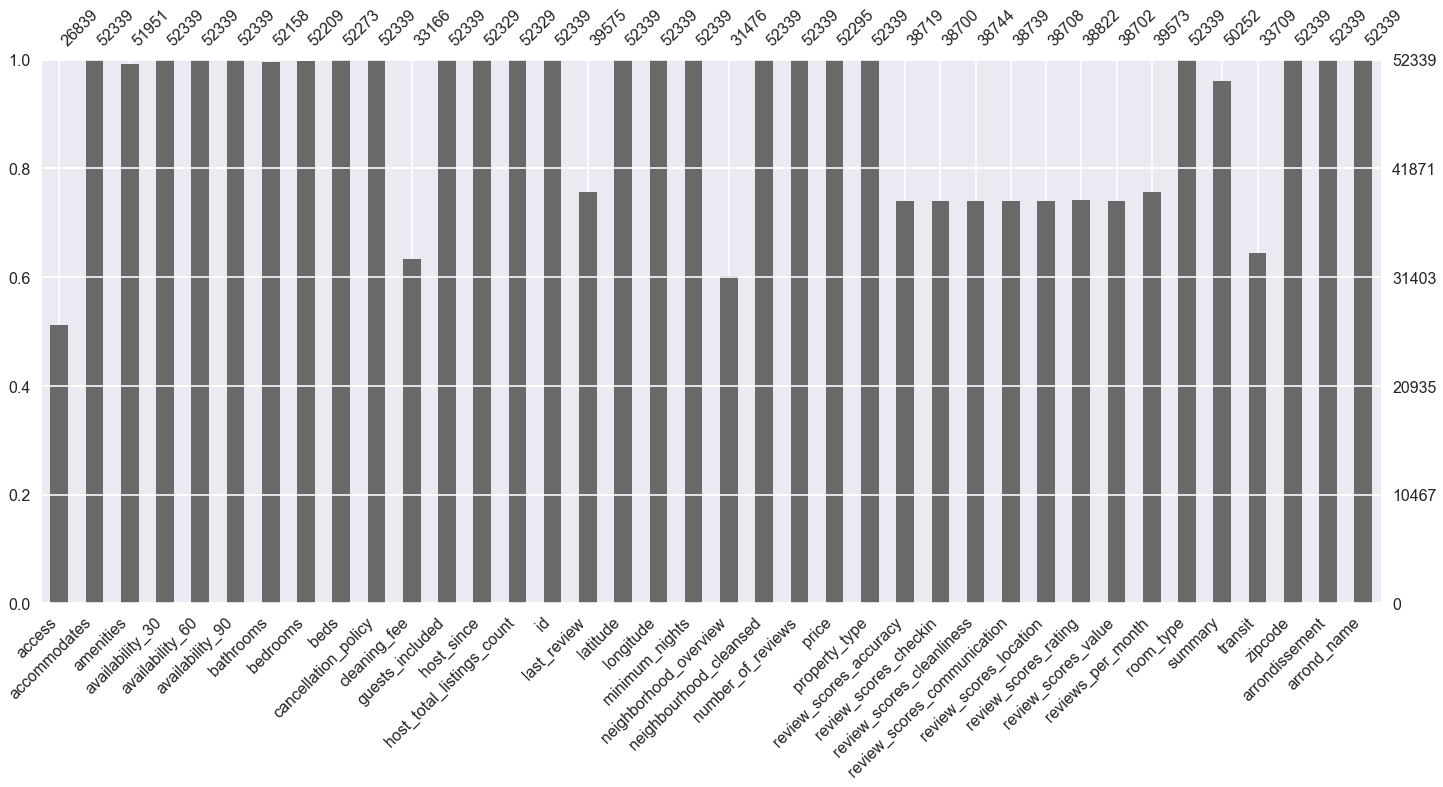

In [28]:
msno.bar(dfParis, labels=True)

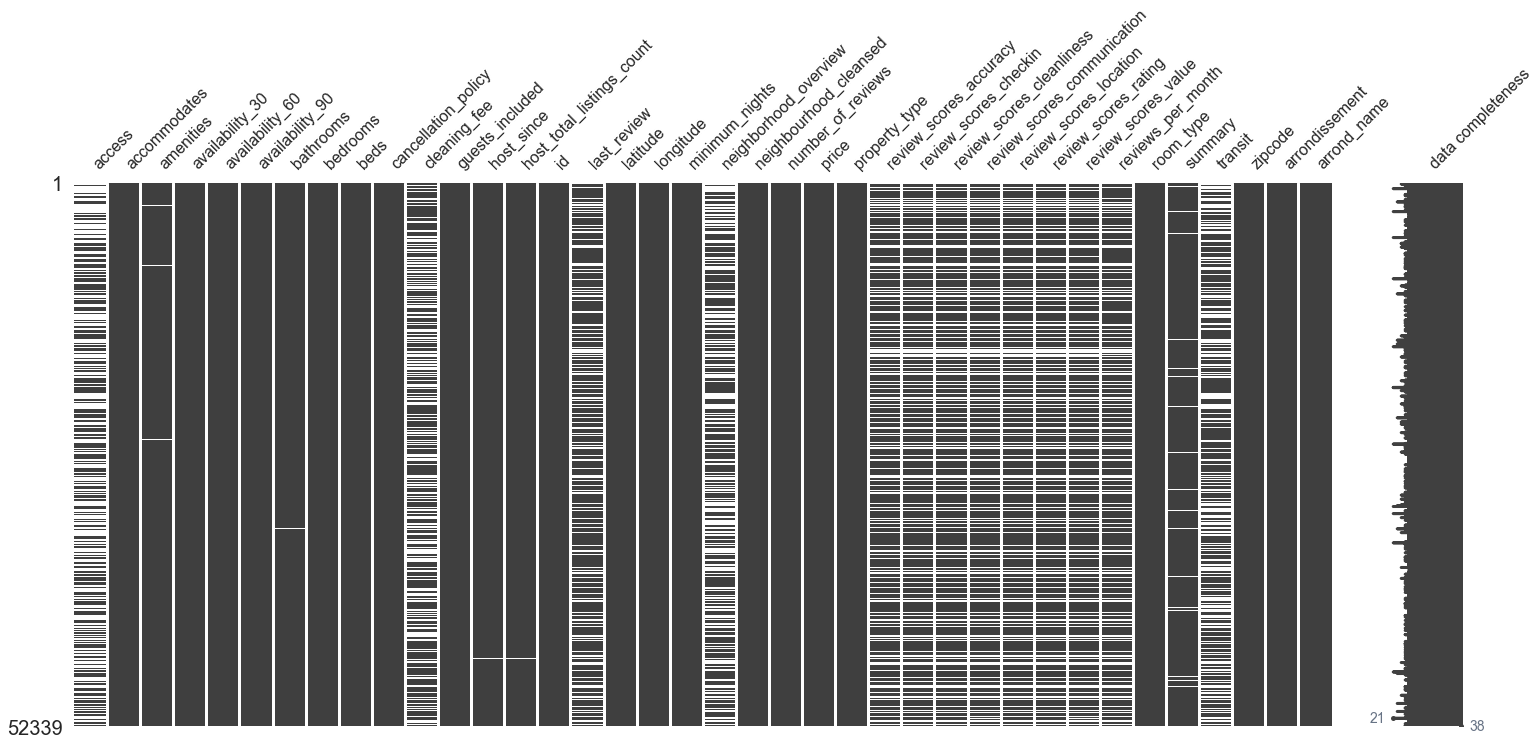

In [29]:
msno.matrix(dfParis, labels=True)

The two graphs above shows that the scores fields do have quite a bit of missing values.

We can label the records as 'rated' vs'unrated', so in our analysis we can compare properties and availabilities for those which are rated, versus those which are not.  Those with incomplete ratings we will label those as well as unrated -- where scores_review_ratings is not populated.

In [30]:
def set_rating_ind(row):
    if np.isnan(row['review_scores_rating']) == True:
        return 0
    else:
        return 1

In [31]:
dfParis['rating_ind'] = dfParis.apply(lambda x: set_rating_ind(x), 1)

We can delete additional columns:  access, cleaning fee, and neighborhood_overview since they will not be relevant in our analysis

In [32]:
try:
    dfParis = dfParis.drop(['access','cleaning_fee','neighborhood_overview'], axis=1)
except:
    print('columns do not exist')

Remove all rows with missing values in the 'price' column, since they will not be useful in the analysis.  

In [35]:
delrows = dfParis[dfParis.price.isnull()]
dfParis = pd.merge(dfParis, delrows[['id']], how='outer', on='id', indicator=True)

try:
    dfParis = dfParis[dfParis['_merge']=='left_only']
    dfParis.drop('_merge', axis=1)
except:
    print('column does not exist')
    
len(dfParis)

52295

In [36]:
dfParis[['availability_30','availability_60', 'availability_90','bathrooms','bedrooms','beds','minimum_nights','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
availability_30,52295,8,10,0,0,3,14,30
availability_60,52295,18,21,0,0,7,35,60
availability_90,52295,29,33,0,0,15,60,90
bedrooms,52165,1,0,0,1,1,1,10
beds,52229,1,1,1,1,1,2,16
minimum_nights,52295,3,62,1,1,2,3,10000
price,52295,93,71,0,55,75,105,999
review_scores_accuracy,38700,9,0,2,9,10,10,10
review_scores_checkin,38681,9,0,2,9,10,10,10
review_scores_cleanliness,38725,9,1,2,9,9,10,10


In [ ]:
#save LT400 file as a pickle file
dfParis.to_pickle('./airbnb_paris/airbnb_Paris_cleansed_0605.p')

###  Exploring the data:  Location and spread of the data

Let us explore the distribution of the property prices. 
Plotting the property prices out, we can see from the graph below it shows that majority of the properties are rented out are below \$200, with the average below \$100 which is at \$94.79, with the median only at $75.  We can see that there are some outliers -- properties over \$400, causing a huge difference between the mean and the median price, and for the distribution to be right skewed.

In [37]:
dfParis['price'].describe()

count    52295.000000
mean        93.718673
std         71.128178
min          0.000000
25%         55.000000
50%         75.000000
75%        105.000000
max        999.000000
Name: price, dtype: float64

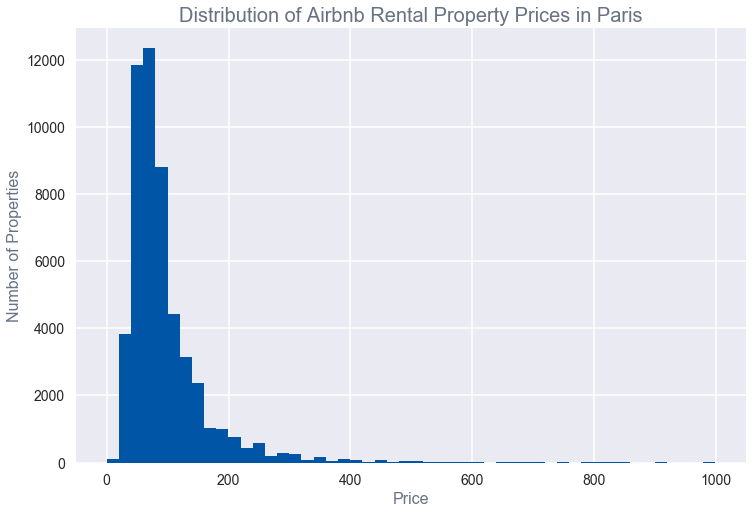

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dfParis.price.dropna(),bins=50)
ax.set_xlabel('Price')
ax.set_ylabel('Number of Properties')
ax.set_title('Distribution of Airbnb Rental Property Prices in Paris')
plt.show()

Comparing the values of some features for properties above \$400 and those less than \$400, we can see that the main differences would be that the average number of beds and bedrooms (bigger accomodations) are higher for the higher priced properties, which is expected for properties with more bedrooms - larger accomodations to be more expensive than those properties with 1 bedroom (less accomodation), and availability is higher as well for more expensive properties.

In [113]:
GT400 = dfParis[dfParis['price'] >= 400]
GT400[['availability_30','accommodates','bathrooms','bedrooms','beds','minimum_nights','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value']].describe().astype(int)

,availability_30,accommodates,bedrooms,beds,minimum_nights,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
count,477,477,477,477,477,477,312,312,312,312,312,312,312
mean,12,6,2,3,3,537,9,9,9,9,9,93,9
std,11,2,1,2,3,133,0,0,0,0,0,6,0
min,0,1,0,1,1,400,5,4,5,5,6,60,6
25%,1,4,2,3,2,449,9,9,9,10,10,91,9
50%,10,6,3,4,3,500,10,10,10,10,10,95,9
75%,24,8,4,5,5,600,10,10,10,10,10,99,10
max,30,16,10,16,60,999,10,10,10,10,10,100,10


In [114]:
LT400 = dfParis[dfParis['price']<400]
LT400[['availability_30','accommodates','bathrooms','bedrooms','beds','minimum_nights','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value']].describe().astype(int)

,availability_30,accommodates,bedrooms,beds,minimum_nights,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
count,51818,51818,51688,51752,51818,51818,38388,38369,38413,38408,38377,38491,38371
mean,8,2,1,1,3,89,9,9,9,9,9,91,9
std,10,1,0,0,63,55,0,0,1,0,0,8,0
min,0,1,0,1,1,0,2,2,2,2,2,20,2
25%,0,2,1,1,1,55,9,9,9,10,9,89,9
50%,2,2,1,1,2,75,10,10,9,10,10,93,9
75%,14,4,1,2,3,100,10,10,10,10,10,98,10
max,30,16,10,16,10000,399,10,10,10,10,10,100,10


In [115]:
LT100 = dfParis[dfParis['price']<= 100]
LT100[['availability_30','accommodates','bathrooms','bedrooms','beds','minimum_nights','price','property_type','review_scores_accuracy','review_scores_checkin',
              'review_scores_cleanliness','review_scores_communication','review_scores_location',
              'review_scores_rating','review_scores_value']].describe().astype(int)

,availability_30,accommodates,bedrooms,beds,minimum_nights,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
count,39014,39014,38898,38966,39014,39014,29115,29104,29138,29135,29112,29204,29105
mean,7,2,0,1,3,64,9,9,9,9,9,91,9
std,10,1,0,0,51,20,0,0,1,0,0,8,0
min,0,1,0,1,1,0,2,2,2,2,2,20,2
25%,0,2,0,1,1,50,9,9,9,10,9,88,9
50%,1,2,1,1,2,65,10,10,9,10,10,93,9
75%,12,3,1,2,3,80,10,10,10,10,10,97,10
max,30,16,10,16,9999,100,10,10,10,10,10,100,10


#### Exploring the 'beds' variable further, we can see that more than 50% of the properties rented out in Paris have only one bed

In [116]:
dfParis.beds.value_counts()

1.0     29319
2.0     15568
3.0      4405
4.0      1833
5.0       662
6.0       275
7.0        78
8.0        42
16.0       18
9.0        16
10.0        5
11.0        4
14.0        2
13.0        1
12.0        1
Name: beds, dtype: int64

In [117]:
dfParis.beds.describe()

count    52229.000000
mean         1.673840
std          1.024185
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: beds, dtype: float64

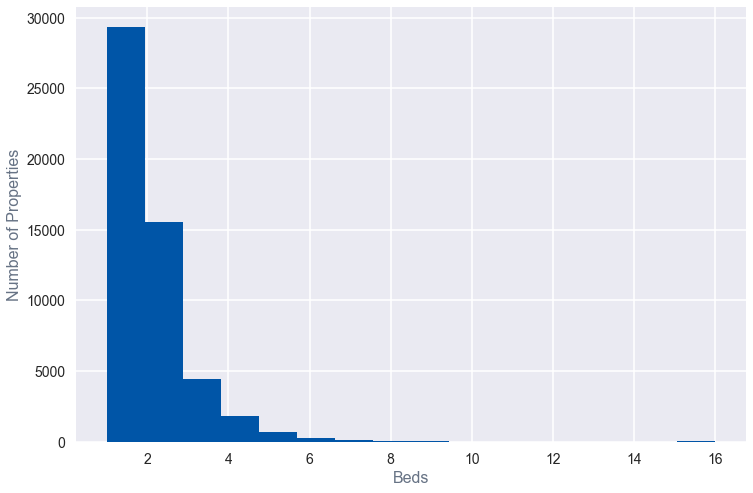

In [118]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dfParis.beds.dropna(),bins=16)
ax.set_xlabel('Beds')
ax.set_ylabel('Number of Properties')
plt.show()

In [119]:
#check for skewness and kurtosis - measure of whether the data is heavily tailed relative to the normal distribution:

dfParis[['beds','price','accommodates','availability_30','bedrooms']].apply(scipy.stats.skew)

beds                    NaN
price              3.792818
accommodates       1.590457
availability_30    1.068163
bedrooms                NaN
dtype: float64

In [120]:
dfParis[['beds','price','accommodates','availability_30','bedrooms']].apply(scipy.stats.kurtosis)

beds                     NaN
price              23.740114
accommodates        5.170135
availability_30    -0.380329
bedrooms                 NaN
dtype: float64

In [121]:
dfParis[['price']].apply(np.log).apply(scipy.stats.skew)

price   NaN
dtype: float64

In [122]:
dfParis[['price']].apply(np.log).apply(scipy.stats.kurtosis)

price   NaN
dtype: float64

it appears that we have some missing values for beds and bedroom variables, and accommodates value is greater than 0.
for rows where beds value is missing, i think it would be safe to assume and set this to the same value as bedrooms

In [123]:
temp = dfParis.copy()

In [37]:
def fill_missing_beds(row):
    #print(row['id'], row['bedrooms'])
    return row['bedrooms']

In [38]:
temp[temp.beds.isnull()]['beds'] = temp[temp.beds.isnull()].apply(lambda x: fill_missing_beds(x), 1)

AttributeError: 'dict' object has no attribute 'beds'

In [84]:
temp['beds'].isnull().sum()

66

Let us further explore to see how price varies by zip code before we exclude the properties over $400 in our dataset.

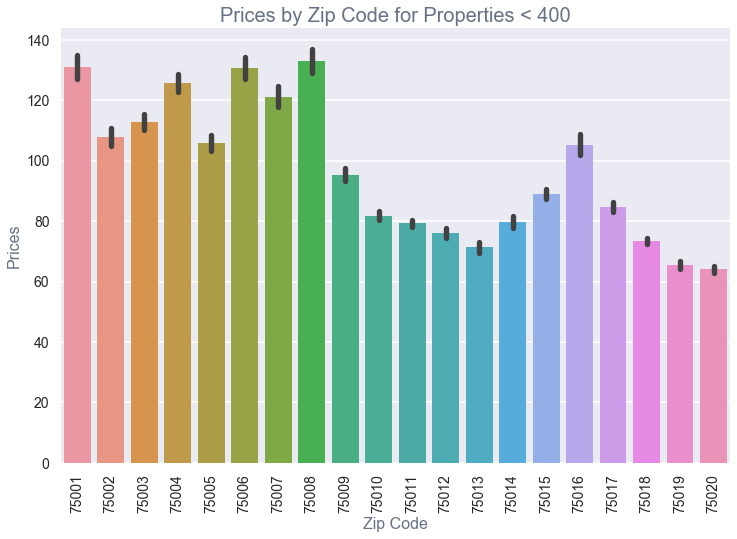

In [125]:
LT400 = LT400.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='price', data=LT400) 
ax.set_title('Prices by Zip Code for Properties < 400') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=LT400['zipcode'].unique(),rotation=90) 

In [126]:
#availability by zip code

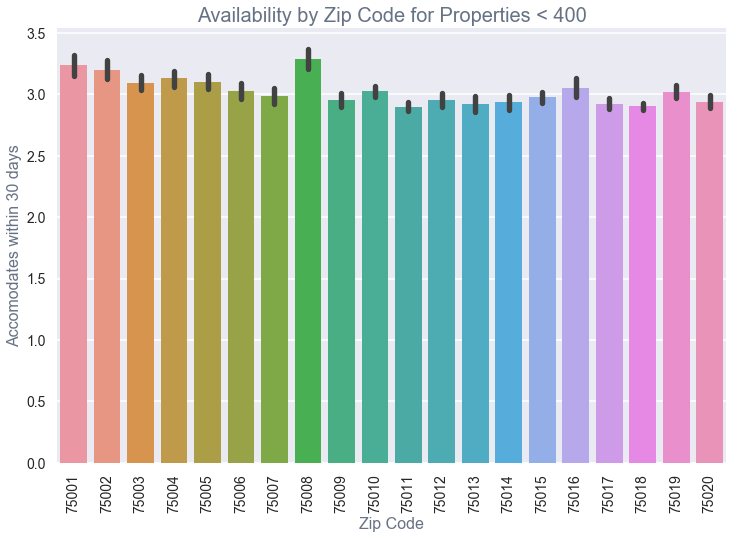

In [127]:
LT400 = LT400.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='accommodates', data=LT400) 
ax.set_title('Availability by Zip Code for Properties < 400') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Accomodates within 30 days') 
ax.set_xticklabels(labels=LT400['zipcode'].unique(),rotation=90) 

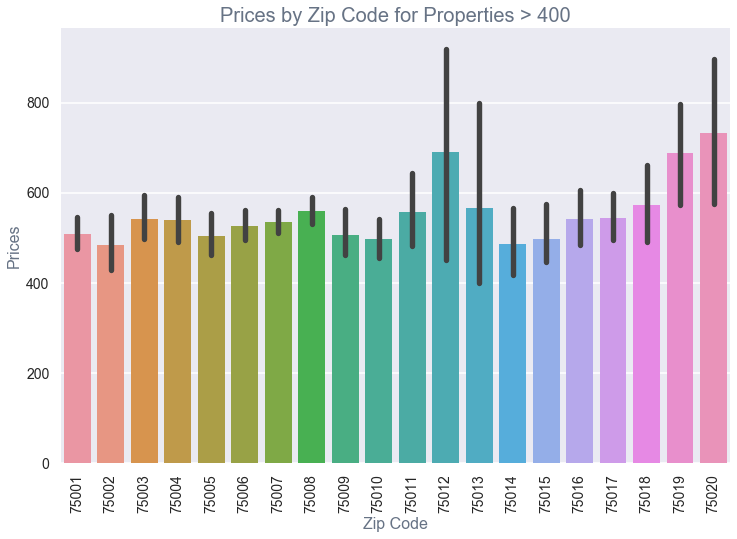

In [128]:
GT400 = GT400.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='price', data=GT400) 
ax.set_title('Prices by Zip Code for Properties > 400') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=LT400['zipcode'].unique(),rotation=90) 

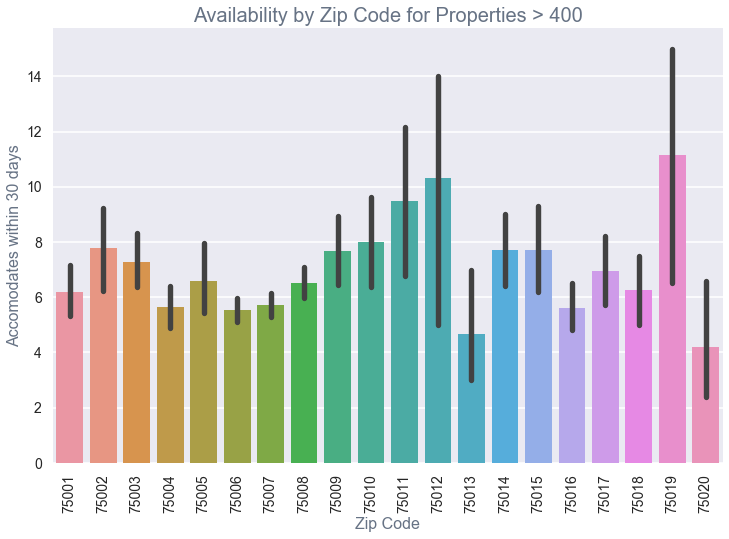

In [129]:
GT400 = GT400.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='accommodates', data=GT400) 
ax.set_title('Availability by Zip Code for Properties > 400') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Accomodates within 30 days') 
ax.set_xticklabels(labels=GT400['zipcode'].unique(),rotation=90) 

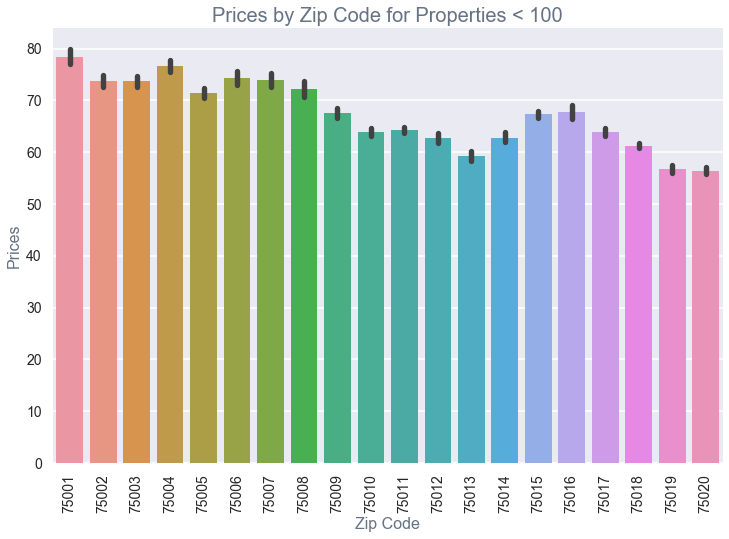

In [130]:
LT100 = LT100.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='price', data=LT100) 
ax.set_title('Prices by Zip Code for Properties < 100') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=LT100['zipcode'].unique(),rotation=90) 

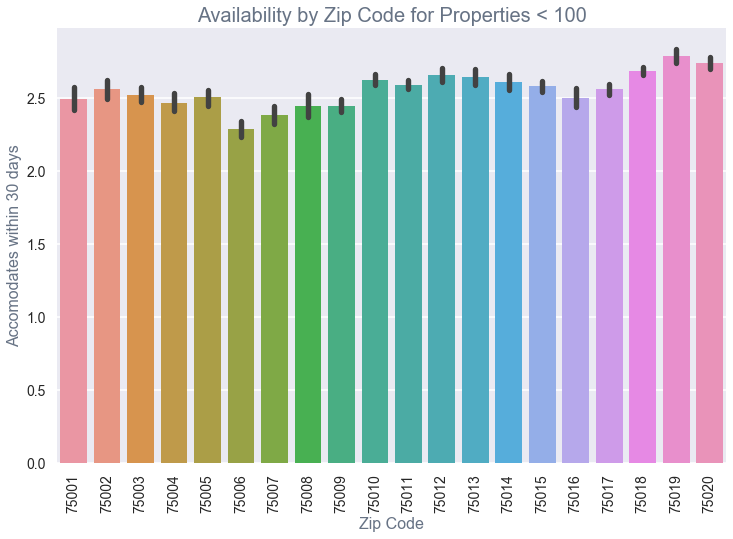

In [131]:
LT100 = LT100.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='accommodates', data=LT100) 
ax.set_title('Availability by Zip Code for Properties < 100') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Accomodates within 30 days') 
ax.set_xticklabels(labels=LT100['zipcode'].unique(),rotation=90) 

In [61]:
Paris_attractions = {'attraction':["Eiffel Tower","The Louvre","Champs-Elysees",
                                   "Musee d'Orsay","Tuileries Garden","Jardin du Luxembourg",
                                   "Ile de la Cite","Musee Rodin","Le Marais"],
                     'latitude': [48.8584,48.8606,48.870502,48.86,48.8635,48.8462,48.8549,48.8553,48.8587],
                     'longitude': [2.2945,2.3376,2.304897,2.3266,2.3275,2.3372,2.3475,2.3158,2.3588],
                     'arrondissement': [7,1,8,7,1,6,4,7,3]}

In [62]:
df_attractions = pd.DataFrame(Paris_attractions)

Top attractions in Paris are in Arrondissements 1 through 8:



In [64]:
df_attractions[['attraction','arrondissement']]

,attraction,arrondisement
0,Eiffel Tower,7
1,The Louvre,1
2,Champs-Elysees,8
3,Musee d'Orsay,7
4,Tuileries Garden,1
5,Jardin du Luxembourg,6
6,Ile de la Cite,4
7,Musee Rodin,7
8,Le Marais,3


The graph above does show that the average price for properties in the zip codes/arrondisements with an attraction, 
are higher compare to those areas with no popular tourist attraction. 

Now for a traveler who will be staying several nights in the city and would like to 
stay below 100 euros a night for the lodging, we can explore how the options for properties in
Arrondisements 1 through 8 compare to those outside of these area.

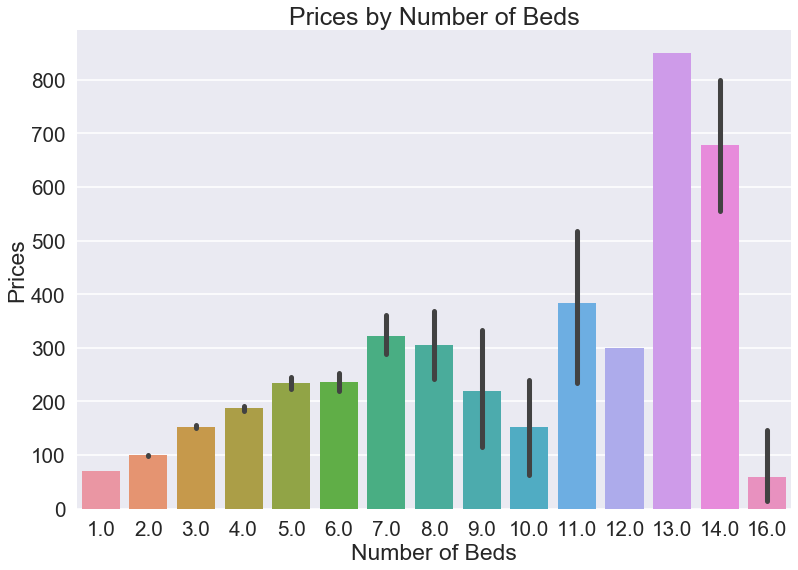

In [74]:
dfBeds = dfParis.sort_values(by='beds')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='beds', y='price', data=dfBeds) 
ax.set_title('Prices by Number of Beds') 
ax.set_xlabel('Number of Beds') 
ax.set_ylabel('Prices') 
#ax.set_xticklabels(labels=LT400['zipcode'].unique(),rotation=90) 

In [75]:
dfParis['review_scores_rating'].describe()

count    38803.000000
mean        91.847873
std          8.280433
min         20.000000
25%         89.000000
50%         93.000000
75%         98.000000
max        100.000000
Name: review_scores_rating, dtype: float64

In [76]:
delratings = dfParis[dfParis.review_scores_rating.isnull()]
ratings = pd.merge(dfParis, delratings[['id']], how='outer', on='id', indicator=True)
ratings = ratings[ratings['_merge']=='left_only']
len(ratings)

38803

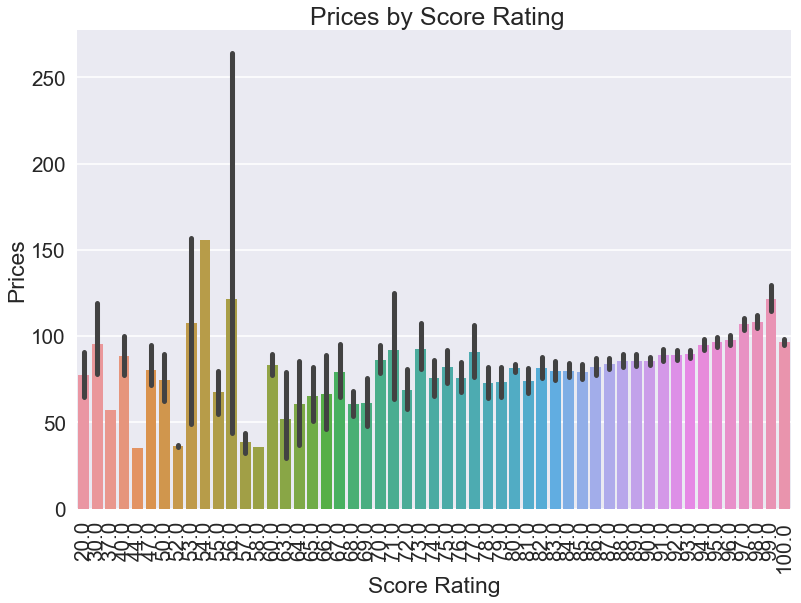

In [81]:
ratings = ratings.sort_values(by='review_scores_rating')
fig = plt.figure(figsize=(12,12))
bar, ax = plt.subplots() 
ax = sns.barplot( x='review_scores_rating', y='price', data=ratings) 
ax.set_title(' Prices by Score Rating') 
ax.set_xlabel('Score Rating') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=ratings['review_scores_rating'].unique(),rotation=90) 

In [82]:
#Group records by Score Rating i.e. < 50, 50-70, 70-80, 80-90, 90-99, 100

In [125]:
def group_by_score(row):
    if row['review_scores_rating'] < 50:
        return '< 50'
    elif (row['review_scores_rating'] >= 50) & (row['review_scores_rating'] < 70):
        return '50-69'
    elif (row['review_scores_rating'] >= 70) & (row['review_scores_rating'] < 80):
        return '70-79'
    elif (row['review_scores_rating'] >= 80) & (row['review_scores_rating'] < 90):
        return '80-89'
    elif (row['review_scores_rating'] >= 90) & (row['review_scores_rating'] < 100):
        return '90-99'
    elif (row['review_scores_rating'] == 100):
        return '100'

In [127]:
ratings['score_group'] = ratings.apply(lambda x: group_by_score(x), 1)
ratings.head()

,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode,_merge,score_group
44584,2,"Wireless Internet,Kitchen,Heating,Family/kid f...",0,1,1.0,2.0,flexible,1,2016-01-15,1.0,16374206,48.87229117172399,2.3761637056185108,2,Entrepôt,1,45.0,Apartment,10.0,10.0,2.0,10.0,10.0,20.0,6.0,Entire home/apt,Studio de 13M2 très bien agencé qui peut acceu...,NaN,75019,left_only,< 50
5536,4,"Internet,Wireless Internet,Kitchen,Heating,Fam...",0,1,1.0,2.0,moderate,1,2014-06-14,1.0,3320193,48.8427334763069,2.2893438051466033,1,Vaugirard,1,55.0,Apartment,2.0,8.0,2.0,8.0,10.0,20.0,4.0,Entire home/apt,"Ce deux-pièces simple, accueillant et fonction...",L'appartement est à 200 m du métro Félix Faure...,75015,left_only,< 50
37292,3,"Internet,Wireless Internet,Wheelchair accessib...",0,1,2.0,2.0,flexible,1,2014-06-17,1.0,3347434,48.88055574034984,2.2963830158629843,15,Batignolles-Monceau,1,40.0,Apartment,10.0,10.0,2.0,10.0,8.0,20.0,2.0,Entire home/apt,A moins de dix minutes à pied de l'Arc de Trio...,"Métro ; Ternes (Ligne 2),Péreire (ligne 3) Eto...",75017,left_only,< 50
47145,4,"TV,Internet,Wireless Internet,Kitchen,Heating,...",0,1,1.0,2.0,strict,2,2013-07-16,1.0,1388924,48.87212636465051,2.3837342300562296,7,Ménilmontant,3,50.0,Apartment,4.0,5.0,4.0,4.0,6.0,20.0,6.0,Shared room,NaN,NaN,75020,left_only,< 50
50310,2,"TV,Wireless Internet,Kitchen,Smoking allowed,H...",16,1,1.0,1.0,moderate,1,2012-12-19,1.0,16434011,48.87414463273343,2.365931131839508,3,Entrepôt,2,46.0,Apartment,4.0,6.0,2.0,2.0,8.0,20.0,2.0,Entire home/apt,Le quartier est tres vivant avec une laverie a...,Metro republique,75010,left_only,< 50


In [129]:
def group_by_price(row):
    if row['price'] < 50:
        return '< 50'
    elif (row['price'] >= 50) & (row['price'] < 100):
        return '50-99'
    elif (row['price'] >= 100) & (row['price'] < 200):
        return '100-199'
    elif (row['price'] >= 200) & (row['price'] < 300):
        return '200-299'
    elif (row['price'] >= 300) & (row['price'] < 400):
        return '300-399'
    elif (row['price'] > 400):
        return '> 400'

In [130]:
ratings['price_group'] = ratings.apply(lambda x: group_by_price(x), 1)
ratings.head()

,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode,_merge,score_group,price_group
44584,2,"Wireless Internet,Kitchen,Heating,Family/kid f...",0,1,1.0,2.0,flexible,1,2016-01-15,1.0,16374206,48.87229117172399,2.3761637056185108,2,Entrepôt,1,45.0,Apartment,10.0,10.0,2.0,10.0,10.0,20.0,6.0,Entire home/apt,Studio de 13M2 très bien agencé qui peut acceu...,NaN,75019,left_only,< 50,< 50
5536,4,"Internet,Wireless Internet,Kitchen,Heating,Fam...",0,1,1.0,2.0,moderate,1,2014-06-14,1.0,3320193,48.8427334763069,2.2893438051466033,1,Vaugirard,1,55.0,Apartment,2.0,8.0,2.0,8.0,10.0,20.0,4.0,Entire home/apt,"Ce deux-pièces simple, accueillant et fonction...",L'appartement est à 200 m du métro Félix Faure...,75015,left_only,< 50,50-99
37292,3,"Internet,Wireless Internet,Wheelchair accessib...",0,1,2.0,2.0,flexible,1,2014-06-17,1.0,3347434,48.88055574034984,2.2963830158629843,15,Batignolles-Monceau,1,40.0,Apartment,10.0,10.0,2.0,10.0,8.0,20.0,2.0,Entire home/apt,A moins de dix minutes à pied de l'Arc de Trio...,"Métro ; Ternes (Ligne 2),Péreire (ligne 3) Eto...",75017,left_only,< 50,< 50
47145,4,"TV,Internet,Wireless Internet,Kitchen,Heating,...",0,1,1.0,2.0,strict,2,2013-07-16,1.0,1388924,48.87212636465051,2.3837342300562296,7,Ménilmontant,3,50.0,Apartment,4.0,5.0,4.0,4.0,6.0,20.0,6.0,Shared room,NaN,NaN,75020,left_only,< 50,50-99
50310,2,"TV,Wireless Internet,Kitchen,Smoking allowed,H...",16,1,1.0,1.0,moderate,1,2012-12-19,1.0,16434011,48.87414463273343,2.365931131839508,3,Entrepôt,2,46.0,Apartment,4.0,6.0,2.0,2.0,8.0,20.0,2.0,Entire home/apt,Le quartier est tres vivant avec une laverie a...,Metro republique,75010,left_only,< 50,< 50


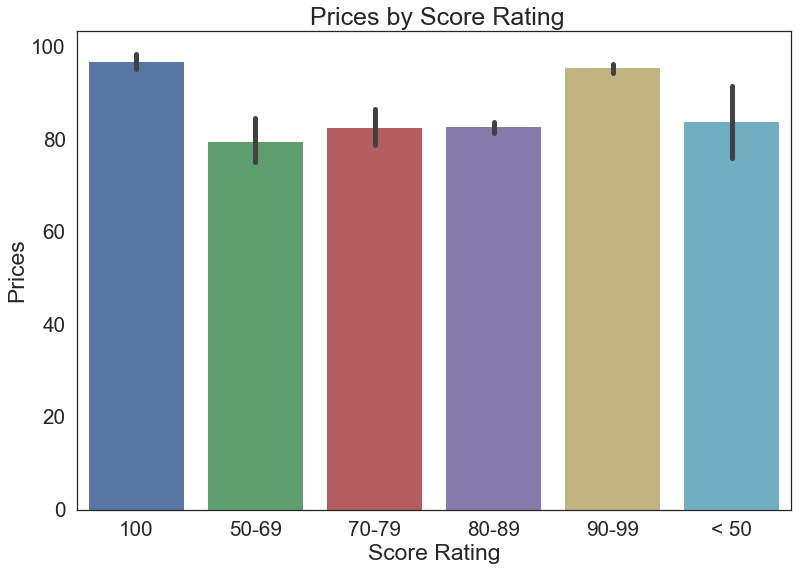

In [134]:
ratings = ratings.sort_values(by='score_group')
fig = plt.figure(figsize=(8,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='score_group', y='price', data=ratings) 
ax.set_title(' Prices by Score Rating') 
ax.set_xlabel('Score Rating') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=ratings['score_group'].unique()) 

In [83]:
#Replot to visualize prices against scores

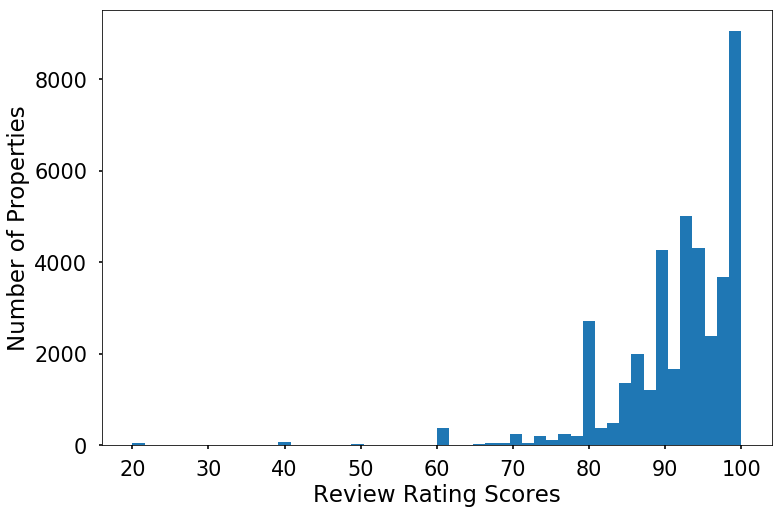

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dfParis.review_scores_rating.dropna(),bins=50)
ax.set_xlabel('Review Rating Scores')
ax.set_ylabel('Number of Properties')
plt.show()

In [81]:
#looking at zip codes it appears that zip codes 75001 through 75020 corresponds to 1st Arrondisement through 20th Arrondisemant in the city,
#analysis will be focused in these zip codes.

zipcodes = [str(x) for x in range(75001, 75021) ]
dfbyZip = dfParis[dfParis['zipcode'].isin(zipcodes)]
dfbyZip['zipcode'].value_counts()


75018    6260
75011    5312
75015    3951
75010    3782
75017    3520
75020    3040
75019    2843
75009    2375
75003    2198
75012    2134
75014    2134
75005    1998
75004    1922
75013    1915
75006    1833
75007    1614
75002    1582
75016    1446
75008    1378
75001    1102
Name: zipcode, dtype: int64

In [85]:
len(dfbyZip.price)


52339

Drop rows with a null value in the 'price' column

In [90]:
delZip = dfbyZip[dfbyZip.price.isnull()]

In [91]:
delZip

,access,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode
4363,This apartment in Paris is located in one of t...,6,"TV,Cable TV,Internet,Wireless Internet,Air con...",9,3,3.0,3.0,moderate,100.0,1,2015-09-03,5.0,13567685,48.875385057039644,2.2937396468263196,4,The best location in Paris. In front of the a...,Batignolles-Monceau,2,NaN,Apartment,10.0,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,With 300 m² in one of the most exclusive view ...,Subway ligne 1 and 6 (Charles de Gaulle-Etoile...,75017
5150,We propose you a driver service to pick up you...,10,"TV,Wireless Internet,Air conditioning,Kitchen,...",29,4,5.0,5.0,strict,NaN,1,2013-01-20,24.0,14816222,48.83042983416544,2.3219074050201294,3,Commerces : Bank and pharmacy 1min by walk Su...,Observatoire,0,NaN,Villa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,Wonderful villa of 330m² on 3 levels located i...,Subway : Line 4 Alésia 8min by walk,75014
5743,Les voyageurs disposeront de l'accès intégral ...,6,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",0,1,2.0,3.0,strict,NaN,4,2012-07-08,1.0,8620766,48.87223375271178,2.357391495565091,2,"Located at the crossing of Republic, Le Marais...",Entrepôt,15,NaN,Apartment,9.0,10.0,7.0,10.0,8.0,81.0,8.0,Entire home/apt,"A large living room, two comfortable bedrooms,...",Strasbourg Saint Denis subway 2 minutes walk: ...,75010
7705,NaN,2,"TV,Internet,Wireless Internet,Kitchen,Heating",0,1,1.0,2.0,flexible,NaN,1,2015-06-08,1.0,6755931,48.87828985334382,2.3429214309950246,1,"Les quartiers hyper connus , vivants et joyeux...",Opéra,0,NaN,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"Studio lumineux de 21 JUİN à 10 SEPTEMBRE, je...","Gare 2 St.Lazarre, Gare du Nord à 15mn à pied...",75009
9312,NaN,10,"Cable TV,Wireless Internet,Air conditioning,Ki...",26,4.5,5.0,5.0,strict,281.0,2,2012-04-04,1.0,5879293,48.829862971315755,2.321404327443958,3,NaN,Observatoire,3,NaN,House,10.0,10.0,9.0,10.0,9.0,100.0,9.0,Entire home/apt,Villa Alesia is a gem in the city of (URL HIDD...,NaN,75014


In [131]:
d

52295

In [142]:
z = z.drop('_merge', axis=1)
z.head()

,access,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode
0,NaN,4,"TV,Internet,Wireless Internet,Kitchen,Elevator...",0,1,1.0,2.0,moderate,30.0,1,2014-12-05,1.0,13080857,48.85863353454054,2.3012819050784645,1,The Champs de Mars is at the foot of the flat....,Palais-Bourbon,7,210.0,Apartment,10.0,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,The flat is in the heart of Paris at the foot ...,2 metro stations (Alma Marceau line 9 and Ecol...,75007
1,NaN,4,"TV,Wireless Internet,Kitchen,Heating,Family/ki...",8,1,1.0,1.0,strict,NaN,1,2016-12-03,1.0,16227135,48.85432599122943,2.297999669163623,7,NaN,Palais-Bourbon,1,150.0,Apartment,10.0,8.0,10.0,8.0,10.0,80.0,10.0,Entire home/apt,Grand appartement confortable et traversant de...,NaN,75015
2,NaN,4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",9,1,1.0,1.0,strict,55.0,2,2015-02-24,35.0,11908897,48.859675450152054,2.3288315242670463,2,Saint Germain des Pres is the most sought by t...,Palais-Bourbon,34,180.0,Apartment,10.0,9.0,10.0,10.0,10.0,96.0,10.0,Entire home/apt,"In front of the Musée d'Orsay, this apartment ...",Metro Assemblée Nationale Ligne 12 Bus Ligne ...,75007
3,You have full access to each room of the appar...,2,"TV,Internet,Wireless Internet,Kitchen,Indoor f...",0,1,1.0,1.0,moderate,20.0,1,2014-04-13,1.0,7277273,48.85014632780952,2.313832259987705,5,"Cross the Seine, indulge in the most delightfu...",Palais-Bourbon,0,90.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,If you are looking for a real French and Paris...,Three main subway lines (10/12/13) and several...,75007
4,NaN,4,"TV,Wireless Internet,Kitchen,Elevator in build...",10,1,1.0,1.0,strict,20.0,1,2012-09-05,1.0,11292907,48.86132303808956,2.305061971616041,2,Le quartier est propice aux balades. La Tour E...,Palais-Bourbon,7,130.0,Apartment,10.0,10.0,10.0,10.0,10.0,97.0,9.0,Entire home/apt,Appartement 2 pièces tout équipé avec une cham...,Plusieurs lignes de métro et bus desservent l'...,75007


In [143]:
z.columns.values

array(['access', 'accommodates', 'amenities', 'availability_30',
       'bathrooms', 'bedrooms', 'beds', 'cancellation_policy',
       'cleaning_fee', 'guests_included', 'host_since',
       'host_total_listings_count', 'id', 'latitude', 'longitude',
       'minimum_nights', 'neighborhood_overview', 'neighbourhood_cleansed',
       'number_of_reviews', 'price', 'property_type',
       'review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating',
       'review_scores_value', 'room_type', 'summary', 'transit', 'zipcode'], dtype=object)

In [148]:
z.price.head()

0    210.0
1    150.0
2    180.0
3     90.0
4    130.0
Name: price, dtype: float64

In [163]:
zLT400 = zLT400.sort_values(by='zipcode')

[Text(0,0,'75001'),
 Text(0,0,'75002'),
 Text(0,0,'75003'),
 Text(0,0,'75004'),
 Text(0,0,'75005'),
 Text(0,0,'75006'),
 Text(0,0,'75007'),
 Text(0,0,'75008'),
 Text(0,0,'75009'),
 Text(0,0,'75010'),
 Text(0,0,'75011'),
 Text(0,0,'75012'),
 Text(0,0,'75013'),
 Text(0,0,'75014'),
 Text(0,0,'75015'),
 Text(0,0,'75016'),
 Text(0,0,'75017'),
 Text(0,0,'75018'),
 Text(0,0,'75019'),
 Text(0,0,'75020')]

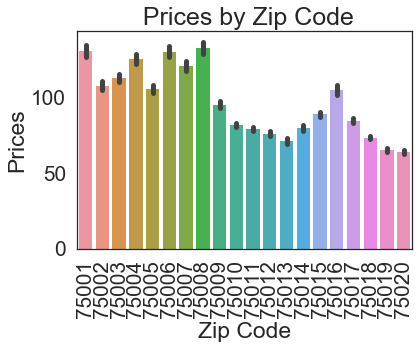

In [166]:
#fig, ax = plt.subplots(figsize=(12,8))
zLT400 = zLT400.sort_values(by='zipcode')
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='price', data=zLT400) 
ax.set_title(' Prices by Zip Code') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Prices') 
ax.set_xticklabels(labels=zLT400['zipcode'].unique(),rotation=90) 

In [157]:
#exclude properties greater than 400 for now

zLT400 = z[z['price']<400]

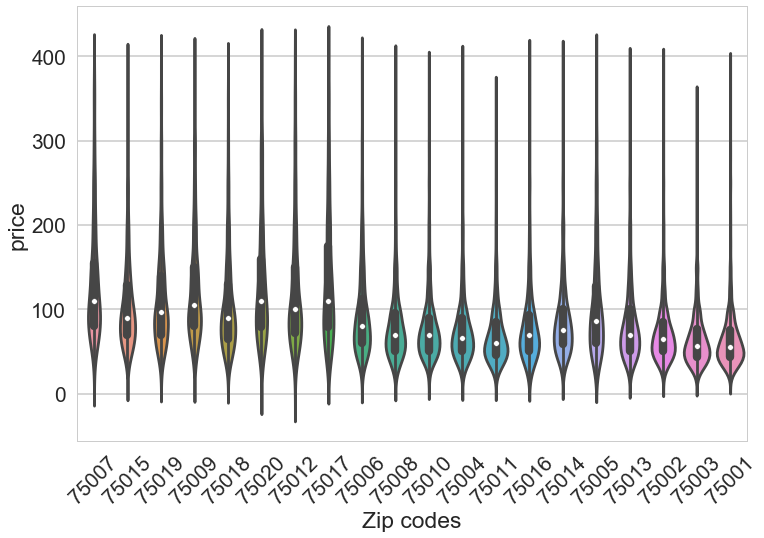

In [162]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set_style("white")
ax = sns.violinplot(x='zipcode', y='price', data=zLT400)
ax.set_xlabel('Zip codes')
ax.set_xticklabels(labels=zLT400['zipcode'].unique(),rotation=45)
plt.show()

In [156]:
z[z['price']> 400]

,access,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode
75,"L'esplanade des Invalides, Le Champs de Mars, ...",6,"TV,Wireless Internet,Kitchen,Elevator in build...",5,2,2.0,3.0,strict,NaN,1,2012-06-18,78.0,3990875,48.849436842040184,2.3195268649682186,3,The rue de Rennes is one of the most commercia...,Palais-Bourbon,0,449.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,This beautiful apartment is very well arranged...,Métros: Vaneau/Sèvres Babylon et Dupleix,75007
175,Vous pourrez profiter de l'ensemble du logemen...,12,"TV,Internet,Wireless Internet,Kitchen,Buzzer/w...",0,2.5,7.0,7.0,strict,100.0,5,2014-05-01,1.0,4152785,48.8766553270601,2.3750602762611193,2,"Quartier de la Butte Bergeyre, atypique et trè...",Buttes-Chaumont,26,495.0,House,10.0,10.0,10.0,10.0,9.0,97.0,9.0,Entire home/apt,"En plein Paris, belle maison années 30, entièr...",Plusieurs stations de métro autour de la maiso...,75019
237,The house is located in the City of Flowers; P...,8,"TV,Internet,Wireless Internet,Family/kid frien...",12,2,5.0,5.0,strict,NaN,1,2012-07-25,21.0,6520357,48.89407606131908,2.3203547552762744,4,The city of flowers is a green area in the hea...,Batignolles-Monceau,2,499.0,House,10.0,10.0,10.0,10.0,6.0,80.0,7.0,Entire home/apt,Come live in this house in the heart of the ci...,Métro Brochant line 13,75017
250,Private access to a garden on the ground floor...,8,"TV,Cable TV,Internet,Wireless Internet,Air con...",0,2,4.0,4.0,moderate,80.0,1,2012-04-25,1.0,10373349,48.881854116527215,2.3834540851075334,4,Green and calm area in front of the Parc des B...,Buttes-Chaumont,2,550.0,House,10.0,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,"Very rare in Paris : architect-designed house,...",Easy access to Metro line 5 ('Laumière' statio...,75019
574,NaN,5,"Internet,Wireless Internet,Kitchen,Hot tub,Buz...",0,1,2.0,3.0,flexible,NaN,1,2015-05-06,1.0,12313735,48.88387960805703,2.297528051933494,1,NaN,Batignolles-Monceau,0,600.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,This lovely parisian apartment consists of two...,NaN,75017
723,You may not have noticed but this property is ...,5,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",2,1,2.0,4.0,strict,50.0,4,2012-10-19,5.0,996171,48.8535381873815,2.3329824049735617,5,NaN,Luxembourg,40,410.0,Apartment,9.0,10.0,9.0,10.0,10.0,93.0,9.0,Entire home/apt,NaN,NaN,75006
724,Access into the apartment is both easy and ver...,8,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",6,3.5,4.0,5.0,strict,150.0,8,2014-04-04,1.0,3600767,48.86599438440638,2.3355214592082216,2,This neighborhood is the most central. It's a ...,Louvre,42,600.0,Apartment,9.0,9.0,9.0,9.0,10.0,94.0,9.0,Entire home/apt,"Luxury, Stylish, Spacious Apartment in the hea...",The Metro station is just downstairs of the bu...,75001
727,Full access to the appartment.,2,"Internet,Wireless Internet,Kitchen,Indoor fire...",30,1,0.0,2.0,flexible,20.0,1,2011-12-09,1.0,11172915,48.86407451989791,2.3476795774277472,3,"Very central pedestrian neighbourhood, full of...",Louvre,7,500.0,Loft,10.0,10.0,9.0,10.0,10.0,94.0,9.0,Entire home/apt,Lovely 48m2 loft in the top center of Paris (d...,Métro RER Chatelet-Les Halles or Etienne Marce...,75002
752,The apartment is entirely yours during the who...,4,"TV,Wireless Internet,Air conditioning,Kitchen,...",7,2,2.0,2.0,strict,80.0,1,2016-03-23,49.0,16075074,48.85193798007143,2.3353046422083144,3,Saint-Germain is located on the Left Bank of t...,Luxembourg,12,500.0,Apartment,10.0,10.0,10.0,10.0,10.0,100.0,10.0,Entire home/apt,Furnished luxury apartment of 1250 sq ft with ...,Metro Statio

In [59]:
dfParis['review_scores_accuracy'].isnull().sum()

14355

In [60]:
dfParis[dfParis['review_scores_accuracy'].isnull()].head()

,access,accommodates,amenities,availability_30,bathrooms,bedrooms,beds,cancellation_policy,cleaning_fee,guests_included,host_since,host_total_listings_count,id,latitude,longitude,minimum_nights,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,summary,transit,zipcode
3,You have full access to each room of the appar...,2,"TV,Internet,Wireless Internet,Kitchen,Indoor f...",0,1,1.0,1.0,moderate,20.0,1,2014-04-13,1.0,7277273,48.85014632780952,2.313832259987705,5,"Cross the Seine, indulge in the most delightfu...",Palais-Bourbon,0,90.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,If you are looking for a real French and Paris...,Three main subway lines (10/12/13) and several...,75007
8,"Parties communes,grand séjour et cuisine",2,"TV,Internet,Wireless Internet,Kitchen,Breakfas...",28,2,1.0,1.0,moderate,NaN,1,2012-05-01,2.0,455620,48.88085461718645,2.3872543428625637,2,"Quartier sympa,cool,avec le parc des Buttes Ch...",Buttes-Chaumont,0,45.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Private room,La chambre beige 17m² refaite a neuf avec véra...,"Lignes 7 bis Botzaris, ligne 5 Ourcq ligne 11...",75019
11,NaN,2,"TV,Wireless Internet,Kitchen,Free parking on p...",14,1,0.0,1.0,moderate,39.0,2,2015-10-05,1.0,16751467,48.87678853219694,2.4017852308300567,2,"Situé entre Porte des Lilas et Télégraphe, les...",Buttes-Chaumont,0,69.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,Cozy apartment well situated between the 19th ...,Metro : • Ligne 11 à 5mn à pied Porte des Lila...,75019
18,salon et chambres,4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",0,1,2.0,3.0,flexible,30.0,2,2015-07-07,1.0,7222101,48.88242852230027,2.3714878279993497,3,"idéal pour marcher, se promener, faire des piq...",Buttes-Chaumont,0,70.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,"50 m2, style parisien , lumineux, 4è étage, 5 ...",métro jaurès (rue secrétan) métro bolivar (rue...,75019
20,NaN,2,"Wireless Internet,Kitchen,Smoking allowed,Heat...",3,1,0.0,1.0,flexible,NaN,1,2017-03-09,1.0,17636380,48.87814144976672,2.3770138415750455,3,NaN,Buttes-Chaumont,0,35.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,Mon logement est proche des Buttes chaumont à ...,NaN,75019


In [168]:
delratings = dfbyZip[dfbyZip.review_scores_rating.isnull()]
z2 = pd.merge(dfbyZip, delratings[['id']], how='outer', on='id', indicator=True)
z2 = z2[z2['_merge']=='left_only']
len(z2)

38822

In [169]:
len(z)

52295

[Text(0,0,'75007'),
 Text(0,0,'75015'),
 Text(0,0,'75019'),
 Text(0,0,'75009'),
 Text(0,0,'75018'),
 Text(0,0,'75012'),
 Text(0,0,'75017'),
 Text(0,0,'75006'),
 Text(0,0,'75020'),
 Text(0,0,'75004'),
 Text(0,0,'75011'),
 Text(0,0,'75010'),
 Text(0,0,'75016'),
 Text(0,0,'75014'),
 Text(0,0,'75005'),
 Text(0,0,'75002'),
 Text(0,0,'75003'),
 Text(0,0,'75001'),
 Text(0,0,'75008'),
 Text(0,0,'75013')]

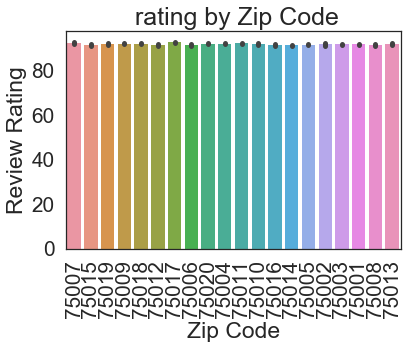

In [174]:
fig = plt.figure(figsize=(12,8))
bar, ax = plt.subplots() 
ax = sns.barplot( x='zipcode', y='review_scores_rating', data=z2) 
ax.set_title(' rating by Zip Code') 
ax.set_xlabel('Zip Code') 
ax.set_ylabel('Review Rating') 
ax.set_xticklabels(labels=z2['zipcode'].unique(),rotation=90) 

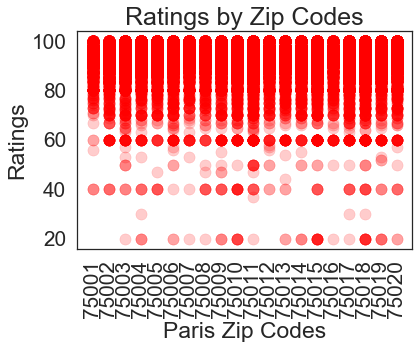

In [187]:
x = z2['zipcode']
y = z2['review_scores_rating']
plt.scatter(x, y, color='red',alpha=0.2)
plt.xlabel('Paris Zip Codes')
plt.xticks(rotation=90)
plt.ylabel('Ratings')
plt.title('Ratings by Zip Codes')
plt.show()

In [191]:
z2.groupby('zipcode').agg({'review_scores_accuracy':'mean','review_scores_checkin':'mean','review_scores_cleanliness':'mean',
                          'review_scores_communication':'mean','review_scores_location':'mean',
                          'review_scores_rating':'mean','review_scores_value':'mean'}).reset_index().sort_values(by='review_scores_rating',ascending=False)



,zipcode,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
6,75007,9.486726,9.653258,9.259051,9.691874,9.891392,92.605939,9.315916
0,75001,9.470460,9.608981,9.238251,9.651366,9.887185,92.456925,9.284775
10,75011,9.532037,9.704268,9.157698,9.734613,9.540534,92.229928,9.288174
3,75004,9.449383,9.626856,9.211598,9.659864,9.925124,92.074507,9.250464
8,75009,9.508187,9.637493,9.229944,9.699944,9.646893,92.069781,9.291196
4,75005,9.489042,9.676065,9.180625,9.687109,9.823308,92.059301,9.242785
2,75003,9.463441,9.662903,9.197956,9.683503,9.820527,92.027375,9.209027
9,75010,9.512556,9.672402,9.183224,9.716449,9.288958,92.018544,9.263611
19,75020,9.530824,9.686588,9.182588,9.713076,9.151601,91.951734,9.301318
17,75018,9.502613,9.667803,9.166061,9.703249,9.094588,91.847742,9.263924


In [41]:
dfParis.price.describe()

count    52295.000000
mean        93.718673
std         71.128178
min          0.000000
25%         55.000000
50%         75.000000
75%        105.000000
max        999.000000
Name: price, dtype: float64

In [40]:
#save LT400 file as a pickle file
dfParis.to_pickle('./airbnb_paris/airbnb_Paris_cleansed_0605.p')

In [39]:
len(dfParis)

52295